# Beijing Housing Deep Learning - Leandro Gregorini

>Environment to run this notebook is available at **environment.yml**

## Inhaltsverzeichnis

* [Imports](#Imports)
* [Analyse](#Analyse)
* [Modell](#Modell)
    * [Datensatz laden](#DatensatzLaden)
    * [Feature Importance](#FeatureImportance)
    * [Daten vorbereiten](#DatenVorbereiten)
    * [Optimizer vorbereiten](#OptimizerVorbereiten)
    * [Modell initialisieren](#ModellInitialisieren)
    * [Modell visualisieren](#ModellVisualisieren)
    * [Modell erstellen](#ModellErstellen)
    * [Modell evaluieren](#ModellEvaluieren)
    * [Modell optimieren](#ModellOptimieren)

## Imports <a class="anchor" id="Imports"></a>

In [32]:
# deep learning libraries
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import keras
import keras_tuner
from tensorflow.keras import regularizers

# machine learning libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# data handling
import numpy as np
import pandas as pd

# visualisierung
%matplotlib inline
import matplotlib.pyplot as plt
import pydot
import graphviz
from keras.utils.vis_utils import plot_model
from keras_visualizer import visualizer

TensorFlow version: 2.4.1


In [3]:
#run_count = 0

In [4]:
# run count for documentation purposes and figure naming
try:
    run_count
except NameError:
    run_count = 0

run_count += 1

print("run_count:", run_count)

run_count: 1


---

## Deep Learning Modell für den Beijing Datensatz <a class="anchor" id="Modell"></a>

### Analyse der Parameter und Begründungen <a class="anchor" id="Analyse"></a>

- **Hidden Layers**
    - **Beschreibung**: <br>
Die mittlere Schicht bzw. Schichten eines Deep Learning Netzwerks werden als "Hidden Layers" bezeichnet.
Die Neuronen dieser Schichten sind weder "Inputs" noch "Outputs".
Die notwendige Anzahl von Ebenen kann beliebig festgelegt werden und es ist oft schwer die "beste" Anzahl zu finden (oft werden jedoch 2 eingesetzt).
<br><br>
<br> Die gängigsten Fälle die eintreten:
<br>- 0 Hidden Layers: Nur in der Lage linear trennbare Funktionen oder Entscheidungen darzustellen
<br>- 1 Hidden Layer: Kann jede Funktion annähern, die eine kontinuierliche Abbildung von einem endlichen Raum zu einem anderen enthält
<br>- 2 Hidden Layers: Kann mit rationalen Aktivierungsfunktionen eine beliebige Entscheidungsgrenze mit beliebiger Genauigkeit darstellen
    <br><br>
    - **Begründung der Auswahl** <br>
Dieser Parameter wurde mit dem Hyperparameter-Tuning evaluiert (min 1, max 3 Hidden Layers).
<br><br>
- **Nodes**
    - **Beschreibung** <br>
Mit der Anzahl Nodes legt man fest, wie viele Neuronen in den verschiedenen Schichten eingesetzt werden. Die Input-Nodes ergeben sich aus der Problemstellung, im Fall vom MNIST Datensatz sind es 784 Neuronen (28x28), diese Zahl wird durch die Anzahl Pixel der Bilder vorgegeben. Die Output-Nodes werden ebenfalls auf die Problemstellung angepasst, im Fall vom MNIST Datensatz sind es 10 Neuronen, da man eine Zahl zwischen 0 und 10 vorhersagen möchte.
<br><br>
<br> Die Anzahl Hidden-Nodes können mit folgenden Faustregeln festgelegt werden:
<br>- Die Anzahl der Hidden-Nodes sollte zwischen der Anzahl Nodes im Input- und Output Layer liegen
<br>- Die Anzahl der Hidden-Nodes sollte 2/3 der Anzahl Nodes im Input Layer plus der Anzahl Nodes im Output Layer sein
<br>- Die Anzahl der Hidden-Nodes sollte weniger als die doppelte Anzahl an Nodes im Input Layer sein.
    <br><br>
    - **Begründung der Auswahl** <br>
Dieser Parameter wurde mit dem Hyperparameter-Tuning evaluiert, jenachdem wieviele Hidden Layers gewählt wurden.
<br><br>
- **Batches**
    - **Beschreibung** <br>
Die batch size definiert die Anzahl an Trainingsdaten, die durch das Netzwerk in einer "Iteration" weitergegeben werden.
<br><br>
Vorteile für das Verwenden einer batch size < Anzahl aller Trainingsdaten:
<br>- Es erfordert weniger Speicher
<br>- Typischerweise trainieren Netzwerke mit Mini-Batches schneller.
<br>
Nachteile:
<br>- Umso kleiner der Batch ist, desto ungenauer wird die Schätzung des Gradienten sein. 
<br><br> Folgende Batch sizes können je nach Hardware eingesetzt werden:
<br>- 1, 2, 4, 8, 16 - eher lange Trainingszeit
<br>- 32 oder 64 - Beim Rechnen mit CPU
<br>- 128 oder 256 - Beim Rechnen mit GPU
    <br><br>
    - **Begründung der Auswahl** <br>
Es wurde eine Batchsize von 32 festgelegt (Standard-Wert).
<br><br>
- **Epochs**
    - **Beschreibung** <br>
Ein kompletter Durchlauf aller Input-Daten wird als Epoche bezeichnet. Dabei können die Input-Daten je nach Größe des Datensatzes auch in gleich große Gruppen (Batches) eingeteilt werden und das Training kann jeweils pro Batch durchgeführt werden.
    <br><br>
    - **Begründung der Auswahl** <br>
Die Zahl der Epochen wird festgelegt auf 10-20, da mit mehr Epochen in diesem Fall keine noch besseren Ergebnisse erzielt werden konnten.
<br><br>
- **Activation function**
    - **Beschreibung** <br>
Die Wahl der Aktivierungsfunktion im Hidden Layer bestimmt, wie gut das Modell den Trainingsdatensatz erlernt.
<br><br>
Folgende Funktionen gibt es für die Hidden Layers:
<br>- Rectified Linear Activation (ReLU)
<br>- Logistic (Sigmoid)
<br>- Hyperbolic Tangent (Tanh)
<br><br>
Folgende Funktionen gibt es für den Output Layer:
<br>- Regression: linear
<br>- Klassifikation: softmax oder sigmoid (sollte nur verwendet werden, wenn mehrere Outputs als "richtige" Antworten gelten sollen)
    <br><br>
    - **Begründung der Auswahl** <br>
Dieser Parameter wurde mit dem Hyperparameter-Tuning evaluiert, zur Auswahl stehen tanh oder relu.
<br><br>
- **Regularization**
    - **Beschreibung** <br>
Mit Regularisierung möchte man Overfitting in neuronalen Netzen reduzieren und somit die Genauigkeit eines Deep Learning Modells bei Anwendung auf komplett neue Daten verbessern.
<br><br>
Es gibt verschiedene Arten der Regularisierung:
<br>- L1-Regularisierung: Kann als eine Art Neuronenselektion betrachtet werden, da sie die Gewichte einiger versteckter Neuronen auf Null bringt.
<br>- L2-Regularisierung: Die Werte der Gewichte werden gegen Null gebracht, was zu einem einfacheren Modell führt.
<br>- Dropout: Die Idee der Dropout-Regularisierung besteht darin, einige Knoten nach dem Zufallsprinzip zu entfernen. Wie bei der L2-Regularisierung vereinfacht sich das Modell und die Komplexität wird somit reduziert.
    <br><br>
    - **Begründung der Auswahl** <br>
Regularisierung wird vorerst nicht verwendet.
<br><br>
- **Optimizer**
    - **Beschreibung** <br>
Optimizer sind Algorithmen oder Methoden, die zur Minimierung einer Fehlerfunktion (Verlustfunktion) oder zur Maximierung der Effizienz eingesetzt werden (Oft "Gradient descent"). Optimizer sind mathematische Funktionen, die von den Parametern des Modells abhängen, d.h. von den weights und biases.
<br> Im Keras Paket gibt es viele Optimizer, welche verwendet werden können, diese sind in der <a href="https://keras.io/api/optimizers/">Dokumentation</a> genauer beschrieben.
<br><br>
Grobe Übersicht:
<br>- Gradient Descent: Batch gradient descent, stochastic gradient descent, mini-batch gradient descent
<br>- Adaptive: Adagrad, Adadelta, RMSprop, Adam
    <br><br>
    - **Begründung der Auswahl** <br>
Als Optimizer wird RMSProp verwendet, dieser wurde entwickelt, um den Optimierungsprozess zu beschleunigen, z.B. um die Anzahl der Funktionsauswertungen zu verringern, die zum Erreichen des Optimums erforderlich sind, oder um die Leistungsfähigkeit des Optimierungsalgorithmus zu verbessern. Es handelt sich dabei um einen Adaptiven Optimizer.

---

### Datensatz laden <a class="anchor" id="DatensatzLaden"></a>

In [52]:
# Preprocessed Daten laden
trainDF = pd.read_csv('../../app/data/02_train.csv', sep=';')
testDF = pd.read_csv('../../app/data/02_test.csv', sep=';')

In [53]:
trainDF.head()

,Lng,Lat,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,renovationCondition,...,placeRank,town,districtPopulation,districtArea,tradeYear,tradeMonth,tradeDay,floorType,constructionTimePeriod,totalPrice
0,116.346109,39.756539,73.61,3,1,1,1,6,118742,53150,...,133606,219943,1993591.0,1012.0,2017,8,6,82499,136686,347.0
1,116.423426,39.964365,58.29,2,1,1,1,5,118742,81641,...,133606,219943,3452460.0,470.8,2013,5,14,82499,136686,317.0
2,116.513137,39.978272,94.47,2,1,1,1,9,118742,81641,...,133606,219943,3452460.0,470.8,2012,12,29,18058,136686,301.5
3,116.473376,39.875385,131.63,3,1,1,2,22,58087,53150,...,81988,219943,3452460.0,470.8,2015,4,9,25725,136686,405.0
4,116.471931,40.008739,103.14,3,2,1,1,18,58087,53150,...,81988,219943,3452460.0,470.8,2017,12,7,82499,136686,670.0


In [54]:
x_train = trainDF.drop(['totalPrice'], axis=1)
y_train = trainDF['totalPrice']
x_test = testDF.drop(['totalPrice'], axis=1)
y_test = testDF['totalPrice']

In [55]:
print(f'Shape x_train : {x_train.shape}')
print(f'Shape x_test : {x_test.shape}')
print(f'Shape y_train : {y_train.shape}')
print(f'Shape y_test : {y_test.shape}')

Shape x_train : (219943, 26)
Shape x_test : (94262, 26)
Shape y_train : (219943,)
Shape y_test : (94262,)


### Feature Importance <a class="anchor" id="FeatureImportance"></a>

best_features: ['square', 'livingRoom', 'bathRoom', 'communityAverage', 'districtArea', 'tradeYear', 'tradeMonth']


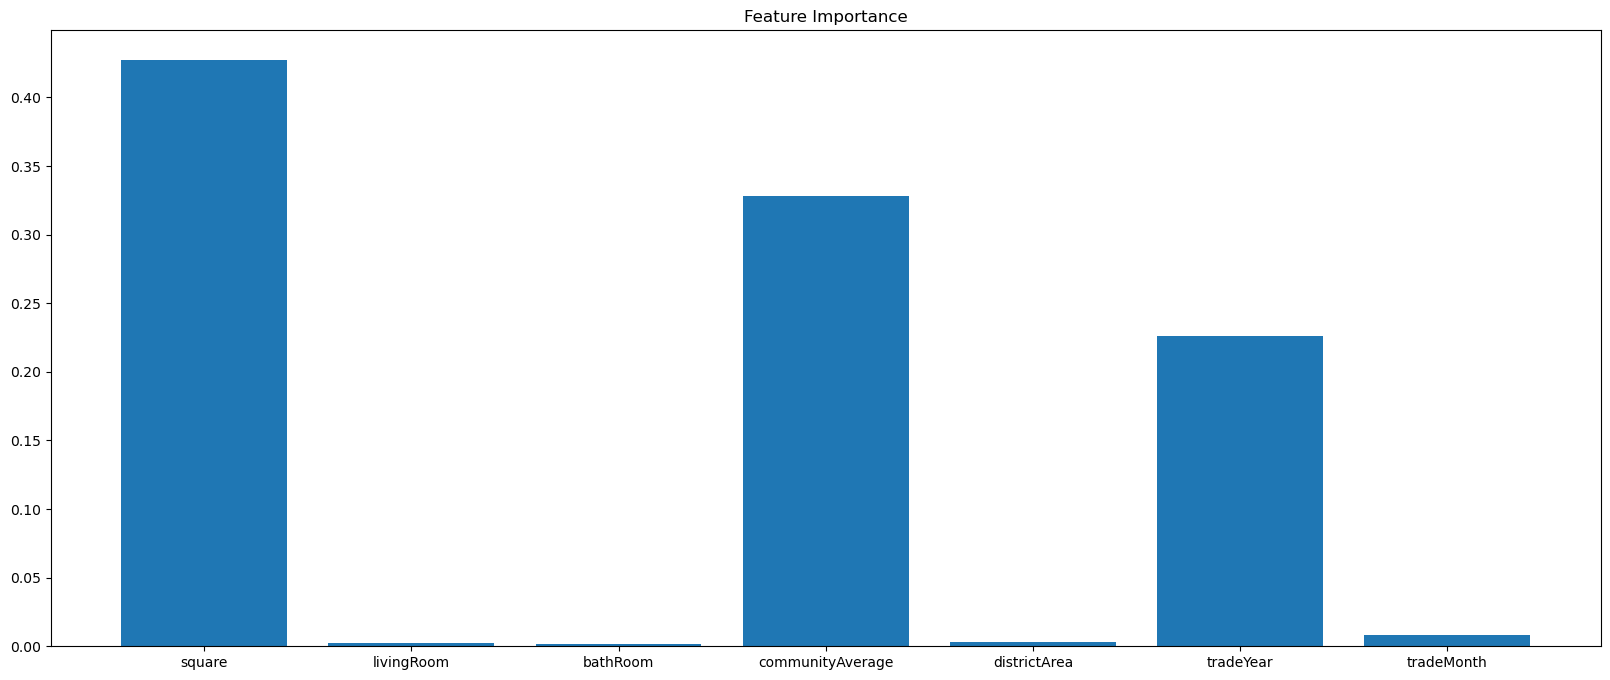

In [9]:
def plot_gb_feature_importance(gb_x_train, min_value=0):
    gb = GradientBoostingRegressor(n_estimators=100)
    gb.fit(gb_x_train, y_train.values.ravel())
    gb_df = pd.DataFrame(gb.feature_importances_, index = gb_x_train.columns.to_list(), columns = ['feature_importance'])  # save scores to df    
    filtered_gb_df = gb_df[gb_df["feature_importance"]>min_value]
    best_features = filtered_gb_df.index.to_list()

    fig = plt.figure(figsize=(20,8))
    plt.bar(filtered_gb_df.index, filtered_gb_df["feature_importance"])
    plt.title("Feature Importance")
    plt.plot()
    return best_features

features_to_analyze = x_train.columns.to_list()
gb_x_train = x_train[features_to_analyze]
best_features = plot_gb_feature_importance(gb_x_train=gb_x_train, min_value=0.001)
print("best_features:", best_features)

In [56]:
x_train = x_train[best_features]
x_test = x_test[best_features]

In [57]:
x_train.head()

,square,livingRoom,bathRoom,communityAverage,districtArea,tradeYear,tradeMonth
0,73.61,3,1,39243.0,1012.0,2017,8
1,58.29,2,1,92516.0,470.8,2013,5
2,94.47,2,1,73113.0,470.8,2012,12
3,131.63,3,2,54612.0,470.8,2015,4
4,103.14,3,1,57510.0,470.8,2017,12


### Daten vorbereiten/skalieren <a class="anchor" id="DatenVorbereiten"></a>

> Skalieren der Spalten mit kontinuierlichen Werten

In [58]:
col_names = ['square', 'communityAverage']
x_train_features = x_train[col_names]
x_test_features = x_test[col_names]

scaler = StandardScaler().fit(x_train_features.values)  # Fit scaler on train data

In [59]:
# apply scaler to train/test data
x_train_features_scaled = scaler.transform(x_train_features.values)
x_train[col_names] = x_train_features_scaled
x_test_features_scaled = scaler.transform(x_test_features.values)
x_test[col_names] = x_test_features_scaled

In [60]:
x_train

,square,livingRoom,bathRoom,communityAverage,districtArea,tradeYear,tradeMonth
0,-0.259247,3,1,-1.099733,1012.0,2017,8
1,-0.668724,2,1,1.288390,470.8,2013,5
2,0.298304,2,1,0.418592,470.8,2012,12
3,1.291527,3,2,-0.410771,470.8,2015,4
4,0.530038,3,1,-0.280859,470.8,2017,12
...,...,...,...,...,...,...,...
219938,-0.690107,2,1,0.374840,470.8,2012,12
219939,-1.047998,1,1,-0.551576,426.0,2012,7
219940,1.465528,3,2,0.724050,426.0,2011,12
219941,0.363254,2,1,1.243158,46.5,2015,3


In [61]:
x_test

,square,livingRoom,bathRoom,communityAverage,districtArea,tradeYear,tradeMonth
0,0.553559,2,1,-1.138240,1430.0,2015,11
1,0.506785,2,1,-1.138240,1430.0,2013,7
2,-0.810117,2,2,0.623994,470.8,2016,10
3,-0.492050,2,1,0.524610,46.5,2016,7
4,-0.379792,2,1,-0.074964,46.5,2016,2
...,...,...,...,...,...,...,...
94257,0.750547,2,2,-0.506972,1430.0,2012,12
94258,0.376618,2,1,-1.070505,980.0,2013,10
94259,0.280664,3,1,0.265504,470.8,2012,8
94260,-0.455165,1,1,-0.696236,870.0,2015,8


### Optimizer vorbereiten <a class="anchor" id="OptimizerVorbereiten"></a>

In [62]:
# Funktion für Optimizer je nach Auswahl in der Konfiguration
def get_optimizer(optimizer_name, learning_rate):
    #'sgd','rmsprop','adam','adagrad'
    optimizer=None

    if optimizer_name == 'adagrad':
        optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)

    elif 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    elif 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    else:
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    return optimizer

### Modell initialisieren - Base Model <a class="anchor" id="ModellInitialisieren"></a>

> Hier wird ein erstes Modell vorbereitet um es später mit dem optimierten Modell vergleichen zu können

> Code-Snippets aus Kurs CDS-108 (siehe Referenzen unten im Dokument)

In [63]:
# Konfiguration des Models (gespeichert in einem dict)
model_config = {
            "INPUT_SHAPE" : (x_train.shape[1],),                # Form des Inputs (Für Boston Housing: Anzahl features)
            "HIDDEN_NODES" : [4,4],                             # Anzahl Neuronen im Hidde Layer (Es werden 2 Hidden-Layers eingesetzt) -> ungefähr 2/3 der Anzahl Input Nodes + Anzahl Output Nodes
            "HIDDEN_ACTIVATION" : "relu",                       # Aktivierungsfunktion im Hidden Layer
            "OUTPUT_NODES" : 1,                                 # Output nodes des Output Layers
            "OUTPUT_ACTIVATION" : None,
            "WEIGHTS_INITIALIZER" : "random_normal",            # Initialisierung der Gewichte
            "BIAS_INITIALIZER" : "ones",                        # Initialisierung des Bias
            "OPTIMIZER" : "rmsprop",                            # Root Mean Square Propagation
            "LEARNING_RATE" : 0.001,                            # Lernrate für "Gradient descent" (0.01 oder 0.1 meist standard)
            "REGULARIZER" : None,                               # Regularisierung (L1, L2)
            "DROPOUT_RATE" : 0.25,                              # Regularisierung (Dropout)
            "DROPOUT": True,                                    # Dropout verwenden oder nicht
            "EPOCHS" : 10,                                      # Anzahl der Epochen, welche trainiert werden sollen
            "BATCH_SIZE" : 32,                                  # Anzahl Daten pro batch
            "VALIDATION_SPLIT" : 0.2,                           # Grösse des Validierungs-Datensatzes
            "VERBOSE" : 1,                                      # Bestimmt die Ausgabe von Infos beim Tranieren des Modells (verbose=0: silent, verbose=1: animierte Anzeige, verbose=2: Zeigt nur die Anzahl Epochen an, welche abgearbeitet wurden)
            "LOSS_FUNCTION" : "mse",                            # Kostenfunktion (MSE für Regression)
            "METRICS" : ["MeanSquaredError"]                    # Optimierungs-Metrik
            }

In [64]:
def prepare_model(model_name, model_config):
    model=tf.keras.models.Sequential(name=model_name)  # Keras Layers in sequentieller Ordnung aufbauen

    for layer in range(len(model_config["HIDDEN_NODES"])):  # Anzahl Hidden Layers
        if layer == 0:
            # Erster Hidden Layer und Input Layer hinzufügen
            model.add(
                    tf.keras.layers.Dense(units=model_config["HIDDEN_NODES"][layer],
                    input_shape=model_config["INPUT_SHAPE"],
                    name="Dense-Layer-" + str(layer),
                    kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                    bias_initializer = model_config["BIAS_INITIALIZER"],
                    kernel_regularizer=model_config["REGULARIZER"],
                    activation=model_config["HIDDEN_ACTIVATION"]))
        
        else:
            # Dropout Normalisierung
            if model_config["DROPOUT"]:
                model.add(tf.keras.layers.Dropout(model_config["DROPOUT_RATE"]))

            # Weitere Hidden Layers hinzufügen
            model.add(
                    tf.keras.layers.Dense(units=model_config["HIDDEN_NODES"][layer],
                    name="Dense-Layer-" + str(layer),
                    kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                    bias_initializer = model_config["BIAS_INITIALIZER"],
                    kernel_regularizer=model_config["REGULARIZER"],
                    activation=model_config["HIDDEN_ACTIVATION"]))


    model.add(tf.keras.layers.Dense(model_config["OUTPUT_NODES"],
                    name="Output-Layer",
                    activation=model_config["OUTPUT_ACTIVATION"]))

    optimizer = get_optimizer(model_config["OPTIMIZER"],
                              model_config["LEARNING_RATE"])

    model.compile(loss=model_config["LOSS_FUNCTION"],
                  optimizer=optimizer,
                   metrics=model_config["METRICS"])
    return model

In [65]:
model = prepare_model(model_name = "BEIJING-MODEL", model_config = model_config)  # load/prepare model

### Modell visualisieren <a class="anchor" id="ModellVisualisieren"></a>

In [43]:
visualizer(model, file_name="BEIJING-MODEL", file_format='png')  # visualizer from keras_visualizer package

<img src="BEIJING-MODEL.png" style="width: 1000px">

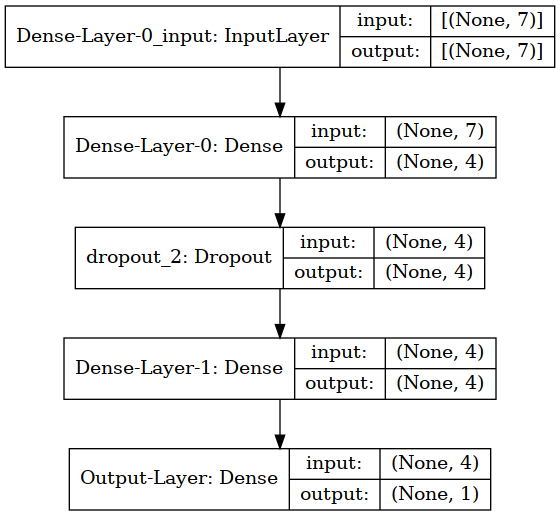

In [66]:
plot_model(model, to_file="BEIJING-MODEL_KERAS.png", show_shapes=True, show_layer_names=True)  # visualizer integrated in keras package

### Modell erstellen und trainieren <a class="anchor" id="ModellErstellen"></a>

In [67]:
model.summary()

Model: "BEIJING-MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense-Layer-0 (Dense)        (None, 4)                 32        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
Dense-Layer-1 (Dense)        (None, 4)                 20        
_________________________________________________________________
Output-Layer (Dense)         (None, 1)                 5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [68]:
def run_model(model, x_train, y_train, stratify):
    X_train, X_val, Y_train, Y_val = train_test_split(
                            x_train, y_train,
                            stratify=stratify,
                            test_size=model_config["VALIDATION_SPLIT"])

    history=model.fit(X_train,
              Y_train,
              batch_size=model_config["BATCH_SIZE"],
              epochs=model_config["EPOCHS"],
              verbose=model_config["VERBOSE"],
              validation_data= (X_val, Y_val))
    return history, model, X_train, Y_train, X_val, Y_val

In [69]:
history, model, X_train, Y_train, X_val, Y_val = run_model(model=model, x_train=x_train, y_train=y_train, stratify=None)  # save trained model and data

Epoch 1/10
5499/5499 [==============================] - 11s 2ms/step - loss: 67960.8945 - mean_squared_error: 67960.8945 - val_loss: 52343.6172 - val_mean_squared_error: 52343.6172
Epoch 2/10
5499/5499 [==============================] - 10s 2ms/step - loss: 50530.1782 - mean_squared_error: 50530.1782 - val_loss: 28811.7617 - val_mean_squared_error: 28811.7617
Epoch 3/10
5499/5499 [==============================] - 10s 2ms/step - loss: 32007.1488 - mean_squared_error: 32007.1488 - val_loss: 23489.7207 - val_mean_squared_error: 23489.7207
Epoch 4/10
5499/5499 [==============================] - 10s 2ms/step - loss: 27466.7415 - mean_squared_error: 27466.7415 - val_loss: 28079.0117 - val_mean_squared_error: 28079.0117
Epoch 5/10
5499/5499 [==============================] - 10s 2ms/step - loss: 26081.6833 - mean_squared_error: 26081.6833 - val_loss: 27414.4316 - val_mean_squared_error: 27414.4316
Epoch 6/10
5499/5499 [==============================] - 10s 2ms/step - loss: 27836.7190 - mean_

### Modell evaluieren <a class="anchor" id="ModellEvaluieren"></a>

In [70]:
print("\n------------------------------------------------------------------------------")
print("Scores")
print("------------------------------------------------------------------------------\n")
print("Train data")
print("x_train MSE:", model.evaluate(X_train, Y_train, verbose=2)[1])
print("\n------------------------------------------------------------------------------")
print("Test data")
print("x_test MSE:", model.evaluate(x_test, y_test, verbose=2)[1])
print("\n------------------------------------------------------------------------------")
print("Validation data")
print("x_val MSE:", model.evaluate(X_val, Y_val, verbose=2)[1])


------------------------------------------------------------------------------
Scores
------------------------------------------------------------------------------

Train data
5499/5499 - 3s - loss: 27025.6230 - mean_squared_error: 27025.6230
x_train MSE: 27025.623046875

------------------------------------------------------------------------------
Test data
2946/2946 - 2s - loss: 25523.5039 - mean_squared_error: 25523.5039
x_test MSE: 25523.50390625

------------------------------------------------------------------------------
Validation data
1375/1375 - 1s - loss: 25137.9375 - mean_squared_error: 25137.9375
x_val MSE: 25137.9375


In [71]:
history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [72]:
def plot_measures_regression(model_name, history=history, title="Measures", accuracy_measures_to_plot=["train_loss", "train_mean_squared_error", "val_loss", "val_mean_squared_error"], savefig=False):
    accuracy_measures={}
    accuracy_measures["train_loss"] = history.history["loss"]
    accuracy_measures["train_mean_squared_error"] = history.history["mean_squared_error"]
    accuracy_measures["val_loss"] = history.history["val_loss"]
    accuracy_measures["val_mean_squared_error"] = history.history["val_mean_squared_error"]
    plt.figure(figsize=(15, 8))
    for measure in accuracy_measures.keys():
        if measure in accuracy_measures_to_plot:
            plt.plot(accuracy_measures[measure], label=measure, linewidth=3)

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Measure")
    plt.legend()
    if savefig:
        plt.savefig(f'figures/{title}.png')
    plt.show()

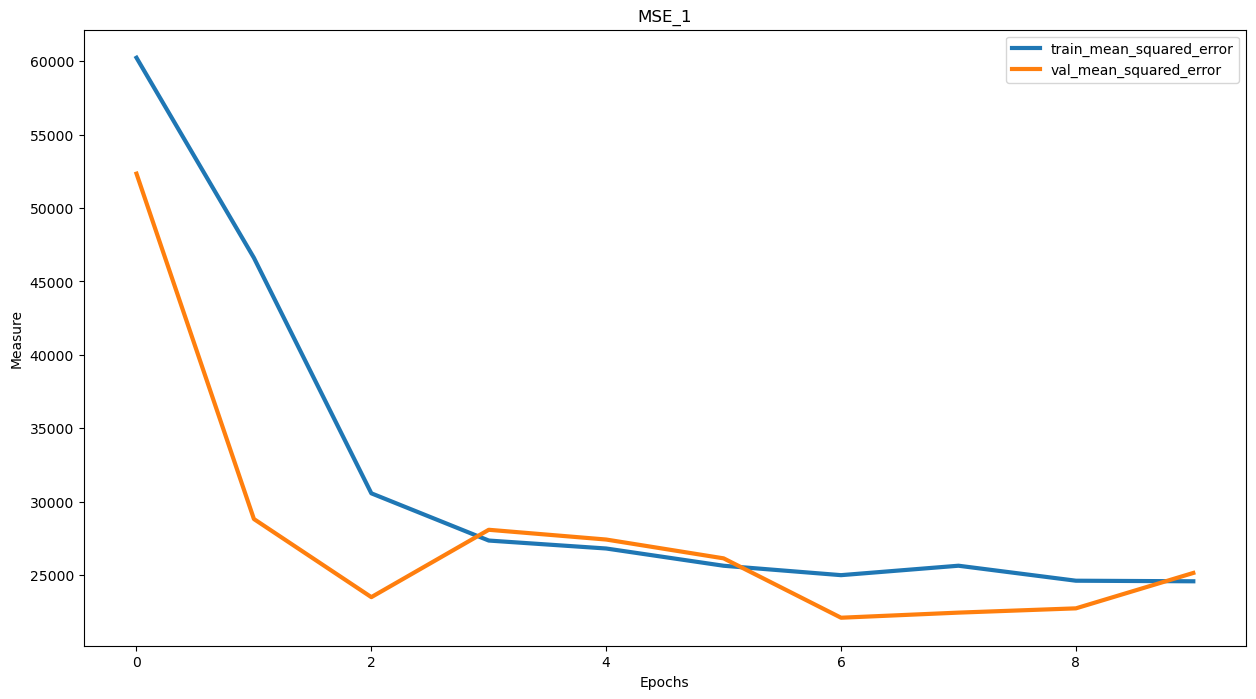

In [73]:
plot_measures_regression(model_name="BEIJING-MODEL", history=history, title=f"MSE_{run_count}",accuracy_measures_to_plot=["train_mean_squared_error", "val_mean_squared_error"], savefig=True)

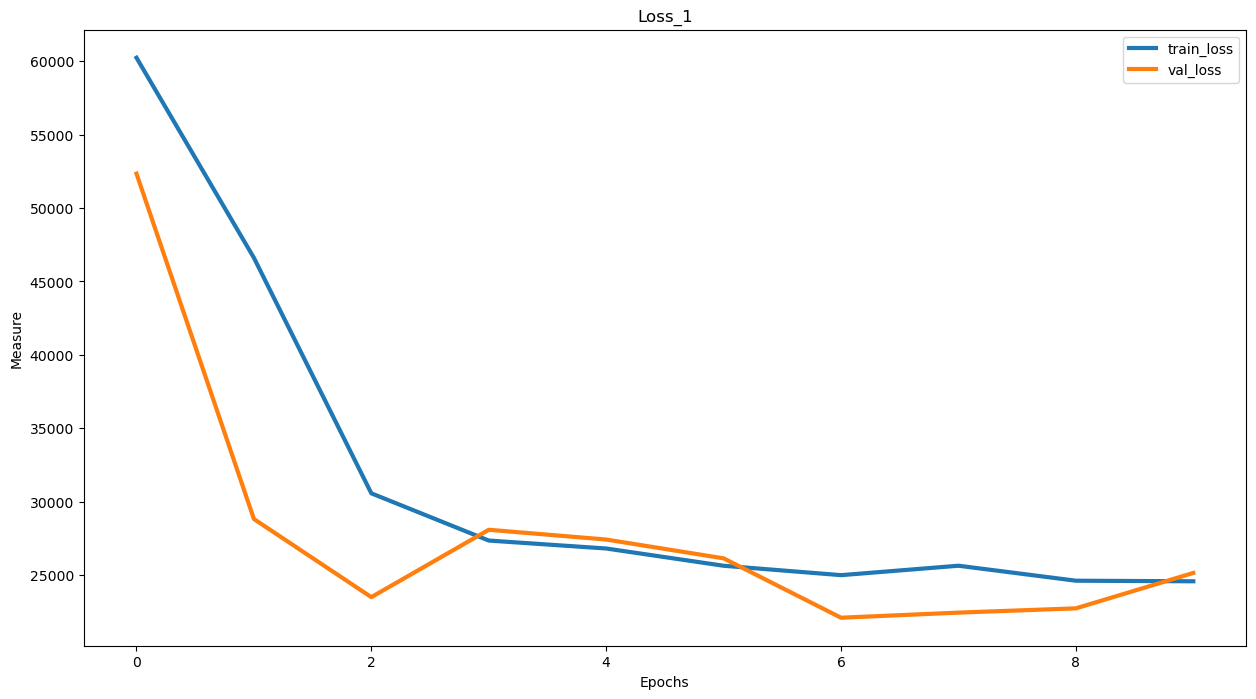

In [74]:
plot_measures_regression(model_name="BEIJING-MODEL", history=history, title=f"Loss_{run_count}", accuracy_measures_to_plot=["train_loss", "val_loss"], savefig=True)

### Modell optimieren - Hyperparameter Tuning <a class="anchor" id="ModellOptimieren"></a>

> Keras Tuner: https://keras.io/guides/keras_tuner/getting_started/

In [78]:
def build_model(hp):
    model = keras.Sequential()
    tf.keras.layers.Flatten(input_shape=(x_train.shape[1],))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            tf.keras.layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=4, max_value=32, step=4, default=4),
                activation=hp.Choice("activation", ["relu", "tanh"], default="relu"),
                kernel_initializer=hp.Choice("kernel_initializer", ["ones", "zeros", "random_normal", "random_uniform"], default="ones"),
                bias_initializer=hp.Choice("bias_initializer", ["ones", "zeros", "random_normal", "random_uniform"], default="random_normal"),
            )
        )
    if hp.Boolean("dropout"):
        model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.01, max_value=0.5, default=0.1, step=0.05)))
    model.add(tf.keras.layers.Dense(1, activation=None))
    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-3, sampling="log")
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=[keras.metrics.MeanSquaredError()],
    )
    return model


build_model(keras_tuner.HyperParameters())

In [79]:
# Setup des Tuners
tuner_rs = keras_tuner.RandomSearch(
            hypermodel=build_model,
            objective=keras_tuner.Objective("val_mean_squared_error", direction="min"),
            seed=42,
            max_trials=10,
            executions_per_trial=1,
            project_name="BEIJING-HOUSING-TUNE",
            directory="keras_tuner_beijing_housing"
            )

INFO:tensorflow:Reloading Tuner from keras_tuner_beijing_housing/BEIJING-HOUSING-TUNE/tuner0.json


In [80]:
tuner_rs.search_space_summary()

Search space summary
Default search space size: 10
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': 4, 'conditions': [], 'min_value': 4, 'max_value': 32, 'step': 4, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
kernel_initializer (Choice)
{'default': 'ones', 'conditions': [], 'values': ['ones', 'zeros', 'random_normal', 'random_uniform'], 'ordered': False}
bias_initializer (Choice)
{'default': 'random_normal', 'conditions': [], 'values': ['ones', 'zeros', 'random_normal', 'random_uniform'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': 4, 'conditions': [], 'min_value': 4, 'max_value': 32, 'step': 4, 'sampling': 'linear'}
dropout_rate (Float)
{

In [82]:
# create val set
X_train, X_val, Y_train, Y_val = train_test_split(
                        x_train, y_train,
                        stratify=None,
                        test_size=0.2)

In [83]:
print("shape X_train/Y_train:", np.shape(X_train), np.shape(Y_train))
print("shape x_test/y_test:", np.shape(x_test), np.shape(y_test))
print("shape x_val/y_val:", np.shape(X_val), np.shape(Y_val))

shape X_train/Y_train: (175954, 7) (175954,)
shape x_test/y_test: (94262, 7) (94262,)
shape x_val/y_val: (43989, 7) (43989,)


In [84]:
tuner_rs.search(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val))  # Hyperparameter Tuning

INFO:tensorflow:Oracle triggered exit


In [60]:
print("num_layers:", tuner_rs.get_best_hyperparameters()[0].get("num_layers"))
print("units_0:", tuner_rs.get_best_hyperparameters()[0].get("units_0"))
print("units_1:", tuner_rs.get_best_hyperparameters()[0].get("units_1"))
print("activation:", tuner_rs.get_best_hyperparameters()[0].get("activation"))
print("dropout:", tuner_rs.get_best_hyperparameters()[0].get("dropout"))
print("lr:", tuner_rs.get_best_hyperparameters()[0].get("lr"))
print("bias_initializer:", tuner_rs.get_best_hyperparameters()[0].get("bias_initializer"))
print("kernel_initializer:", tuner_rs.get_best_hyperparameters()[0].get("kernel_initializer"))

num_layers: 2
units_0: 4
units_1: 4
activation: relu
dropout: False
lr: 0.00012482904754698164
bias_initializer: random_uniform
kernel_initializer: zeros


In [66]:
best_hp = tuner_rs.get_best_hyperparameters()[0]  # Beste Hyperparameter von Keras Tuner speichern
best_model = build_model(best_hp)  # Model direkt mit besten Hyperparameter von Keras Tuner erstellen

In [67]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)  # patience: Number of epochs with no improvement after which training will be stopped.

history=best_model.fit(X_train,
              Y_train,
              batch_size=32,
              epochs=10, 
              callbacks=[callback],
              verbose=2,
              validation_data= (X_val, Y_val))

Epoch 1/10
10998/10998 - 17s - loss: 45730.0781 - mean_squared_error: 45730.0781 - val_loss: 39795.0938 - val_mean_squared_error: 39795.0938
Epoch 2/10
10998/10998 - 16s - loss: 38985.9492 - mean_squared_error: 38985.9492 - val_loss: 28891.5898 - val_mean_squared_error: 28891.5898
Epoch 3/10
10998/10998 - 17s - loss: 24912.7070 - mean_squared_error: 24912.7070 - val_loss: 20961.7949 - val_mean_squared_error: 20961.7949
Epoch 4/10
10998/10998 - 17s - loss: 22931.8750 - mean_squared_error: 22931.8750 - val_loss: 20928.3262 - val_mean_squared_error: 20928.3262
Epoch 5/10
10998/10998 - 16s - loss: 22895.8574 - mean_squared_error: 22895.8574 - val_loss: 21143.0527 - val_mean_squared_error: 21143.0527
Epoch 6/10
10998/10998 - 16s - loss: 22863.7402 - mean_squared_error: 22863.7402 - val_loss: 20911.4219 - val_mean_squared_error: 20911.4219
Epoch 7/10
10998/10998 - 16s - loss: 22891.6113 - mean_squared_error: 22891.6113 - val_loss: 21435.1309 - val_mean_squared_error: 21435.1309
Epoch 8/10
10

In [71]:
print("\n------------------------------------------------------------------------------")
print("Scores")
print("------------------------------------------------------------------------------\n")
print("Train data")
print("x_train MSE:", best_model.evaluate(X_train, Y_train, verbose=2)[1])
print("\n------------------------------------------------------------------------------")
print("Test data")
print("x_test MSE:", best_model.evaluate(x_test, y_test, verbose=2)[1])
print("\n------------------------------------------------------------------------------")
print("Validation data")
print("x_val MSE:", best_model.evaluate(X_val, Y_val, verbose=2)[1])


------------------------------------------------------------------------------
Scores
------------------------------------------------------------------------------

Train data
5499/5499 - 3s - loss: 22918.2168 - mean_squared_error: 22918.2168
x_train MSE: 22918.216796875

------------------------------------------------------------------------------
Test data
2946/2946 - 2s - loss: 21856.6230 - mean_squared_error: 21856.6230
x_test MSE: 21856.623046875

------------------------------------------------------------------------------
Validation data
1375/1375 - 1s - loss: 21477.2988 - mean_squared_error: 21477.2988
x_val MSE: 21477.298828125


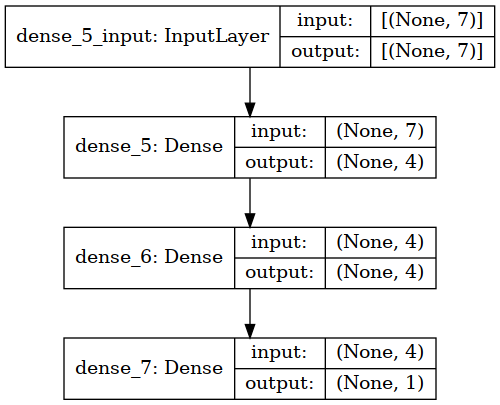

In [72]:
plot_model(best_model, to_file="BEIJING-HOUSING-MODEL-TUNED_KERAS.png", show_shapes=True, show_layer_names=True)  # visualizer integrated in keras package

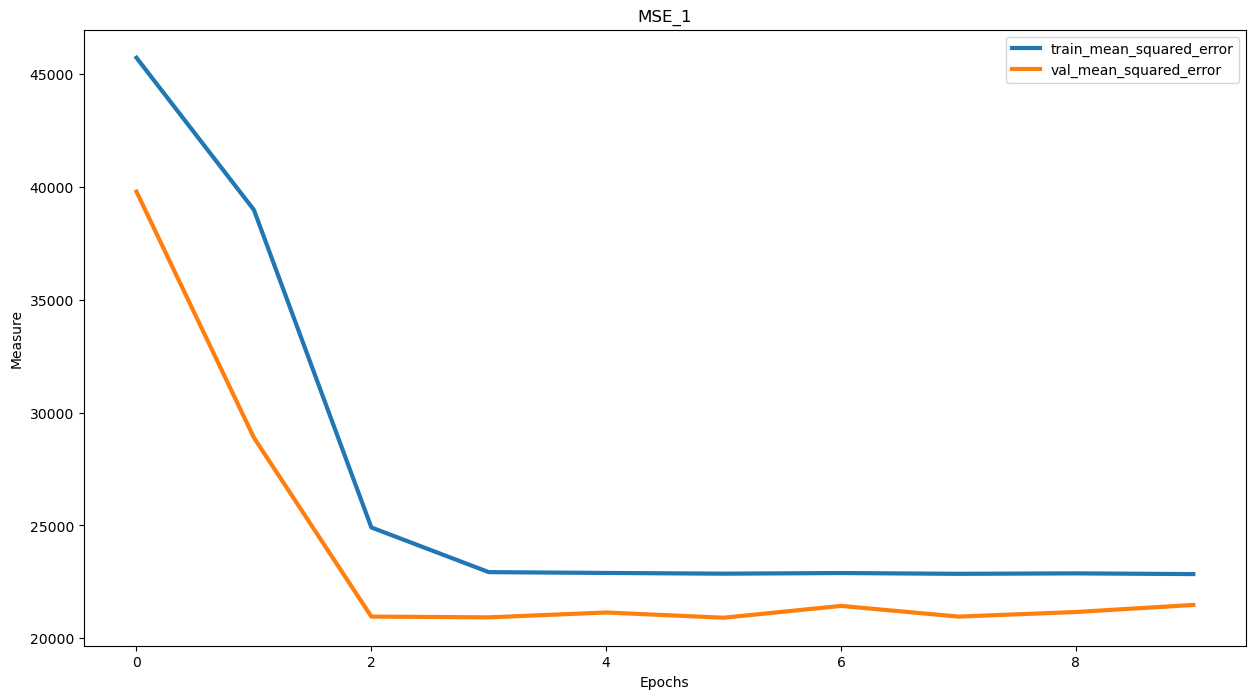

In [73]:
plot_measures_regression(model_name="BEIJING-MODEL", history=history, title=f"MSE_{run_count}",accuracy_measures_to_plot=["train_mean_squared_error", "val_mean_squared_error"], savefig=True)

---

## Referenzen

- Code Snippets/Informationen aus Kurs CDS-108: https://moodle.fhgr.ch/course/view.php?id=14551
- Tensorflow/Keras Doku: https://www.tensorflow.org/datasets/keras_example
- Feature Importance: https://towardsdatascience.com/feature-importance-with-neural-network-346eb6205743
- Hidden Layers: https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3
- Batches: https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
- Batch and Epoch: https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/
- Batch Size: https://stackoverflow.com/questions/35050753/how-big-should-batch-size-and-number-of-epochs-be-when-fitting-a-model#:~:text=Generally%20batch%20size%20of%2032,have%20worked%20fine%20for%20me.
- Activation Function: https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
- Regularization: https://towardsdatascience.com/regularization-techniques-for-neural-networks-379f5b4c9ac3
- Optimizer: https://medium.com/mlearning-ai/optimizers-in-deep-learning-7bf81fed78a0
- Optimizer wählen: https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e
- Best optimizer MNIST: https://towardsdatascience.com/neural-network-optimization-algorithms-1a44c282f61d#:~:text=We%20compared%20different%20optimizers%20used,on%20MNIST%20data%20in%20TensorFlow.
- Boston Housing: https://www.kaggle.com/code/manishkc06/build-your-first-deep-learning-model
- Keras Tuner (Hyperparameter Tuning/Optimization): https://keras.io/keras_tuner/

---